In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
%matplotlib inline

In [20]:
is_cuda = torch.cuda.is_available()

In [3]:
transformation = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307, ), (0.3081, ))
    ]
)

In [4]:
train_dataset = torchvision.datasets.MNIST('data/', train=True, download=True, transform=transformation)
test_dataset = torchvision.datasets.MNIST('data/', train=False, download=True, transform=transformation)

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [6]:
train_loader_iter = train_loader.__iter__()

In [7]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image, cmap='gray')

In [8]:
sample_data = train_loader_iter.__next__()

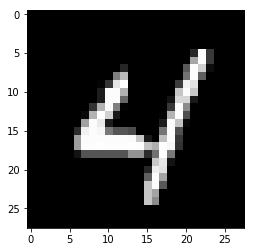

In [9]:
plot_img(sample_data[0][1])

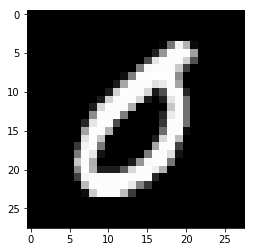

In [10]:
plot_img(sample_data[0][2])

In [11]:
class Net(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [12]:
conv = torch.nn.Conv1d(1, 1, 3, bias=False)

In [13]:
sample = torch.randn(1, 1, 7)

In [14]:
sample

tensor([[[-0.1464,  0.7209, -0.1641,  1.7634, -0.7721,  0.0893, -0.3685]]])

In [15]:
conv(Variable(sample))

tensor([[[-0.2284,  0.4230, -0.6318,  0.2569, -0.1147]]])

In [16]:
conv.weight

Parameter containing:
tensor([[[ 0.0188, -0.2657,  0.2075]]])

In [17]:
def fit(epoch, model, data_loader, phase='training', volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        if is_cuda:
            data = data.cuda()
            target = targed.cuda()
        data = Variable(data, volatile)
        target = Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        running_loss += F.nll_loss(output, target, size_average=False).data[0]
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * running_correct / len(data_loader.dataset)
    print(
        f"{phase}, loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct} / {len(data_loader.dataset)}"
        "{accuracy: 10.4}")
    return loss, accuracy
    
    

In [18]:
model = Net()

In [21]:
if is_cuda:
    model = model.cuda()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
for epoch in range(1, 20):
    epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
    val_epoch_loss, val_epoch_accuracy = fit(epoch, test_loader, model, phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

In [ ]:
plt.plot(range(1, len(train_losses) + 1), train_losses, 'bo', label="training loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r', label="validation loss")
plt.legend()